## Load the Dataset

In [1]:
from rag.load import load_benchmark_corpus_sample, corpus_to_texts_metadatas


benchmark, corpus = load_benchmark_corpus_sample(subset='maud')
texts, metadatas = corpus_to_texts_metadatas(corpus)

In [2]:
from rag.chunk import create_documents


documents = create_documents(
    "Qwen/Qwen3-Embedding-0.6B",
    texts, metadatas,
    chunk_size=500,
    atom_size=200,
    pad=1,
)
documents[:5]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

[Document(metadata={'source_file': 'Domtar Corporation_Paper Excellence Canada Group.txt', 'start_index': 0}, page_content='\ufeffExhibit 2.1 \n\n\nExecution Version     AGREEMENT AND PLAN OF MERGER \n\n\namong \n\n\nDOMTAR CORPORATION, \n\n\nKARTA HALTEN B.V., \n\n\nand \n\n\nPEARL MERGER SUB INC. \n\n\nand \n\n\nPAPER EXCELLENCE B.V. \n\n\nand \n\n\nHERVEY INVESTMENTS B.V. \n\n\nDated as of May 10, 2021    '),
 Document(metadata={'source_file': 'Domtar Corporation_Paper Excellence Canada Group.txt', 'start_index': 259}, page_content='________________'),
 Document(metadata={'source_file': 'Domtar Corporation_Paper Excellence Canada Group.txt', 'start_index': 278}, page_content='TABLE OF CONTENTS         Page  ARTICLE I    DEFINITIONS    Section 1.1   Definitions    6  Section 1.2   Table of Definitions    20  Section 1.3   Other Definitional and Interpretative Provisions    22  ARTICLE II    THE MERGER; EFFECT ON THE CAPITAL STOCK; PAYMENT    Section 2.1   The Merger    23  Section 2.

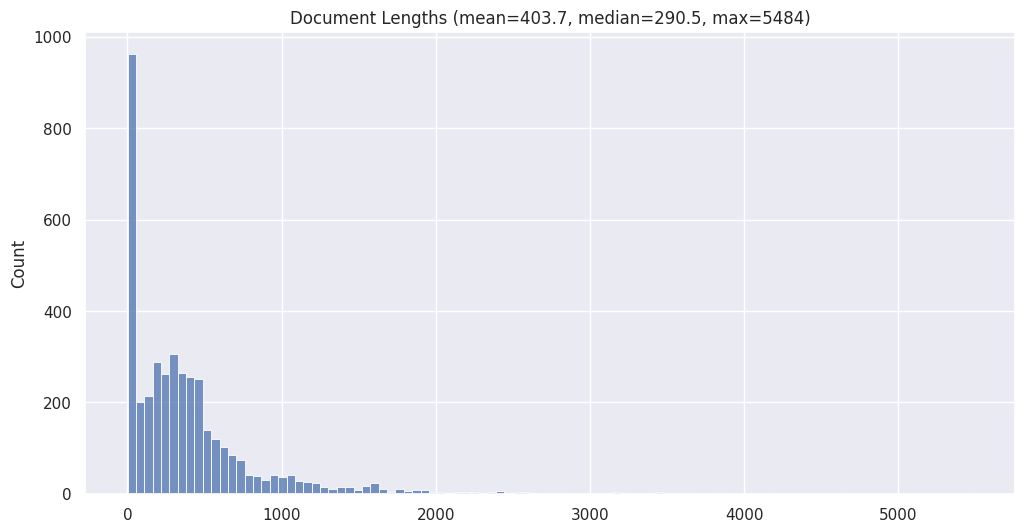

In [3]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(doc.page_content) for doc in documents]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f}, max={max(lengths)})")
plt.show()

In [4]:
from rag.embed import compute_similarities, get_query_strings, get_document_contents

similarities = compute_similarities(
    "Qwen/Qwen3-Embedding-0.6B",
    queries=get_query_strings(benchmark),
    documents=get_document_contents(documents),
)

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
import torch

from rag.metrics import print_evaluations


ranks = torch.argsort(similarities, descending=True)

print("Baseline Evaluation")
print_evaluations(benchmark, documents, ranks)

Baseline Evaluation
precision @ 1 :  0.2306, recall @ 1 :  0.2072
precision @ 2 :  0.2006, recall @ 2 :  0.2841
precision @ 4 :  0.1227, recall @ 4 :  0.3063
precision @ 8 :  0.0927, recall @ 8 :  0.4007
precision @ 16:  0.0640, recall @ 16:  0.5072
precision @ 32:  0.0428, recall @ 32:  0.6249
precision @ 64:  0.0267, recall @ 64:  0.7230
AUC: 0.07685438425213714


In [6]:
from tqdm.notebook import tqdm
import torch

from rag.rerank import rerank


model_path = "ContextualAI/ctxl-rerank-v2-instruct-multilingual-2b"
TOP_K = 32

ranks = torch.argsort(similarities, descending=True)
reranks = rerank(benchmark, documents, ranks, model_path=model_path, topk=TOP_K)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

/home/joshuachin/miniconda3/envs/RAG-2/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [7]:
print(f"Reranked (K={TOP_K}) Evaluation")
print_evaluations(benchmark, documents, reranks)

Reranked (K=32) Evaluation
precision @ 1 :  0.3573, recall @ 1 :  0.3180
precision @ 2 :  0.2460, recall @ 2 :  0.3331
precision @ 4 :  0.1715, recall @ 4 :  0.4032
precision @ 8 :  0.1150, recall @ 8 :  0.5073
precision @ 16:  0.0723, recall @ 16:  0.6010
precision @ 32:  0.0428, recall @ 32:  0.6249
precision @ 64:  0.0428, recall @ 64:  0.6249
AUC: 0.13110514638348433
